<!--Información del curso-->
<img align="left" style="padding-right:10px;" src="figures/banner_sdc.png">

<center><h1 style="font-size:2em;color:#2467C0"> Region of interest and direction
 </h1></center>
<br>
<table>
<col width="550">
<col width="450">
<tr>
<td><img src="figures/direccion.png" align="middle" style="width:550px;"/></td>
<td>
    
    
**Objective:**
    
    
In this lesson we will apply **`OpenCV`** functions to perform the reading of a video, as well as selecting and displaying the region of interest of a road. Finally, the steering algorithm will be shown.
   
<br>
</td>
</tr>
</table>

# Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import time

plt.style.use('seaborn-paper')
plt.rc('font', family='serif')

# Read/load a video

## Open and read every image of a video

As we know, videos are just a set of images that are shown over time, it is like taking a picture every half a second for 2 minutes, we would have a total of 240 images, which we play at 30 fps (frames per second) and at the end we will have a video that lasts approximately 8 seconds.

1. The first thing you do is read a video file (usually **mp4** files). For our case we take _`data/video_road.mp4`_ and with **`cv.VideoCapture()`** we open the file:

```Python
video = cv.VideoCapture("data/video_road.mp4")
```

2. To play the video we have to show the images over time, so we have to show the video as long as there are images in it (obvious for us, not so much for the machine). This is where **`video.isOpened()`** and **`video.read()`** come in.  
 * **`video.isOpened()`** returns a _boolean_ value, where it is **`True`** if the file is open. This action will be inside the condition of a _while loop_ :
  ```Python
while(video.isOpened()):
    ...
```
* What will be inside the **`while`**? **`video.read()`**. This action returns two values, the first is a _boolean_ and the second is an image (the one you are reading). 
  ```Python
while(video.isOpened()):
    ret, frame = video.read()
```
What **`ret`** does is store the boolean variable, this will be **`True`** if an image has been captured and **`False`** when no image has been captured.

3. (We're still inside the **`while`** loop) The variable **`ret`** will be used for a conditional. If it is `True` it will display the image and the "title" of the video in a box:
```Python
while(video.isOpened()):
    ret, frame = video.read()
    if ret == True:
        cv.imshow("Original video", frame)
```

4. Inside the **`if`** statement we're going to store another conditional. This will be used to stop the video and exit when the letter __'q'__ is pressed, **`& 0xFF`** is added when the computer on which the program is running is a 64-bit computer:
  ```Python
while(video.isOpened()):
    ret, frame = video.read()
    if ret == True:
        cv.imshow("video original", frame)
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
```

5. Looking at the **`if ret == True`** something else is missing... What happens when there are no more images to display? We will ask the program to close everything and exit:
  ```Python
while(video.isOpened()):
    ret, frame = video.read()
    if ret == True:
        cv.imshow("video original", frame)
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
```

6. Finally we end with the lines **`video.release()`** and **`cv.destroyAllWindows()`** to show/release the video and close the pop-up windows:
```Python
video.release()
cv.destroyAllWindows()
```

We'll end up with the folliwing code:

```Python
import numpy as np
import cv2 as cv
import time

video = cv.VideoCapture("data/video_road.mp4")
while(video.isOpened()):
    ret, frame = video.read()
    if ret:
        cv.imshow("Original video", frame)
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
video.release()
cv.destroyAllWindows()
```
(This code block is located in the **`L02_show_video.py`** file)

# Binarization function

The next step is to work with the images, where we are going to binarise them and resize them to 480$\times$240 pixels. The function that will do this task is going to read an image and output the same image with other dimensions and binarised:

In [2]:
def binarization(image, size = (480,240)):
    img_gray = cv.cvtColor( src = image,
                           code = cv.COLOR_BGR2GRAY
                          )
    img_gauss = cv.GaussianBlur( src = img_gray,
                                ksize =  (5,5),
                                sigmaX = 0
                               )
    thr, img_thr = cv.threshold( img_gauss,
                                160, #threshold
                                255, #maxval
                                cv.THRESH_BINARY #type of threshold
                               )
    img_r = cv.resize( src = img_thr,
                      dsize = size,
                      interpolation = cv.INTER_NEAREST
                     )
    return (img_r)

## Test the binarization function

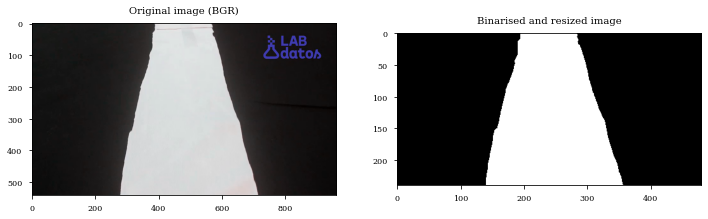

In [3]:
capture = cv.imread( 'data/test_image.jpg' )
capture_bin = binarization(capture)

plt.figure(figsize=(12,8), facecolor= 'white')
plt.axes().set_facecolor('white')

plt.subplot(1,2,1)
plt.title('Original image (BGR)', size = 10, pad = 10 )
plt.imshow(capture)
plt.subplot(1,2,2)
plt.title( 'Binarised and resized image', size = 10, pad = 10 )
plt.imshow(capture_bin,cmap='gray')
plt.show()

## Add binarization function inside the video

We are going to show the binarised video next to the non-binarised video. To do this we will use the same **"Read/load video "** section code by adding a line to the content inside the **`if ret`** . The new lines of code are:
```Python
img_bin = binarization(frame)
cv.imshow("Binarized video", img_bin)
```

_Sample:_
```Python
video = cv.VideoCapture("data/video_road.mp4")
while(video.isOpened()):
    ret, frame = video.read()
    if ret:
        cv.imshow("Original video", frame)
        img_bin = binarization(frame)
        cv.imshow("Binarized video", img_bin)
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
video.release()
cv.destroyAllWindows()
```
(The whole code is in the **`L02_binarized_video.py`**)

# Area of interest function

## Test the function in a static image from the video

We will first work with an image from the video, from the grid view to identify the points, until we get our transformed image.

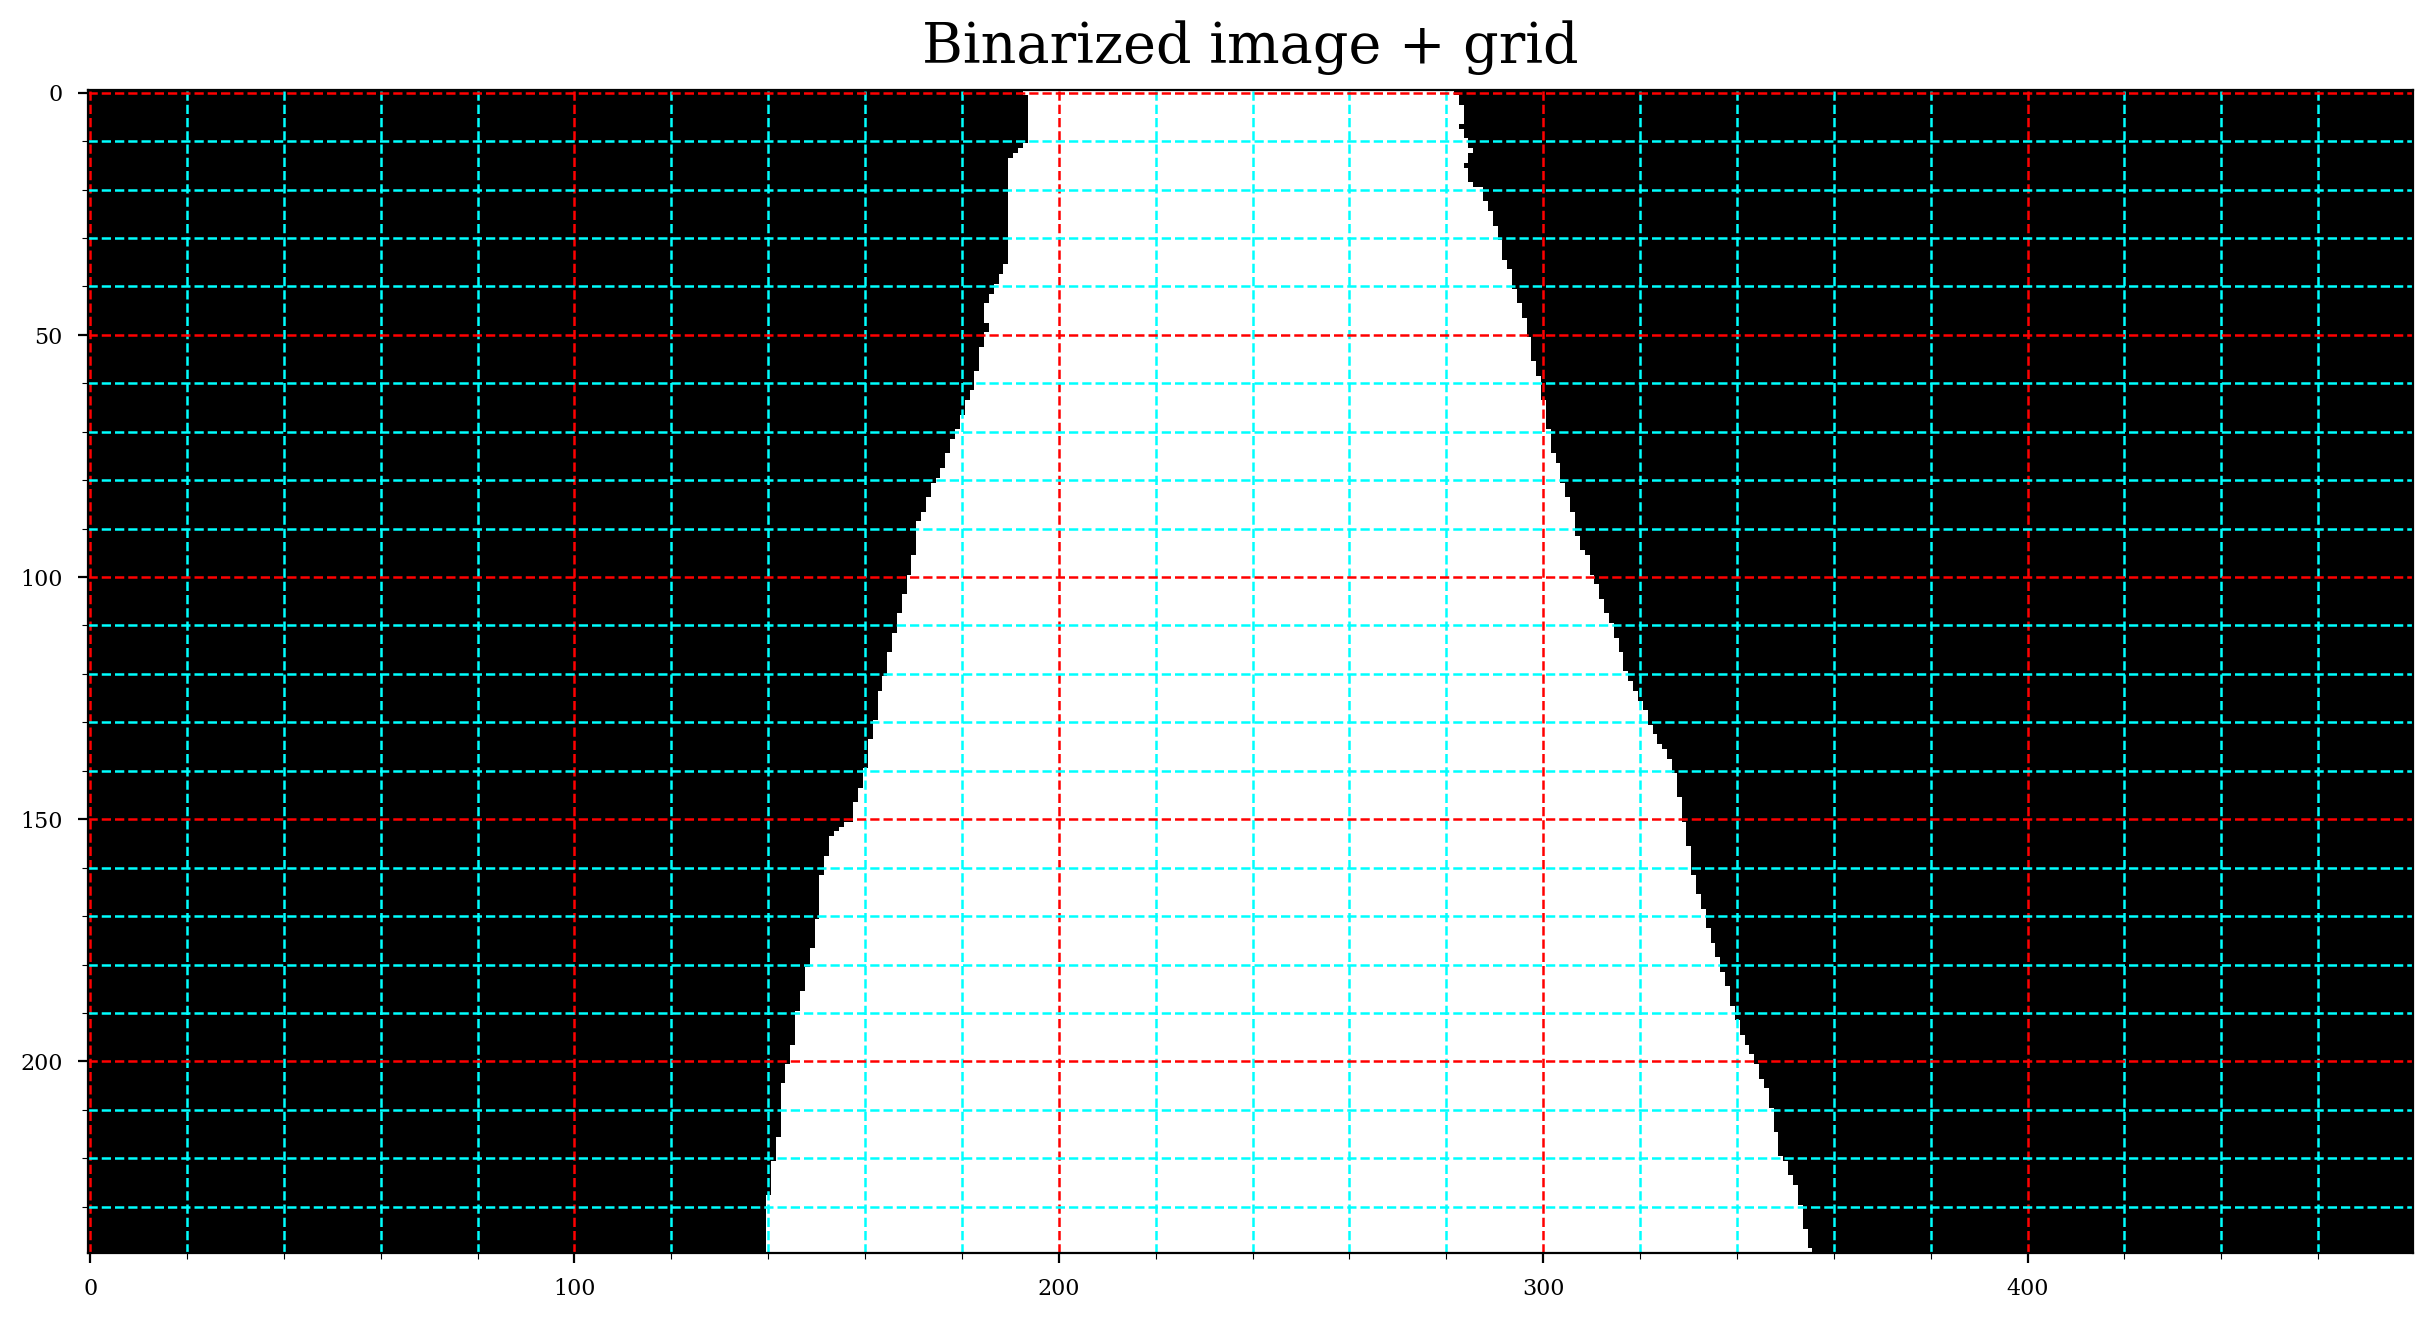

In [4]:
capture = cv.imread( 'data/test_image.jpg' )
capture_bin = binarization(capture)
fig, ax = plt.subplots( figsize = (15,15), facecolor = 'white', dpi = 200 )

#titulo y creación de la figura con sus ejes
ax.set_title('Binarized image + grid', size = 20, pad = 10)
ax.imshow( capture_bin, cmap = 'gray' )

#agregar los dos tipos de grid
ax.minorticks_on()
ax.grid( which = 'major', linestyle ='--', linewidth = 0.9, color = 'red' )
ax.grid( which = 'minor', linestyle ='--', linewidth = 0.9, color = 'cyan' )

### Obtain the polygon's vertices (points)

To obtain the figure of the polygon a polyline needs to be made, this figure can be obtained with the following process:
1. After locating the vertices of the polygon, they have to be stored in an _array_:
```Python
pts_polygon = np.array( [ [ p1[0], p1[1] ],
                         [ p2[0], p2[1] ],
                         [ p4[0], p4[1] ],
                         [ p3[0], p3[1] ] ], dtype = np.int32 )
```
2. After that, we have to reshape the array:
```Python
pts_polygon = pts_polygon.reshape( (-1, 1, 2) )
```
With this form we will get an array of 4 elements, each element has an array of two elements.

3. We are going to use this array to create a polyline in the image with **`cv.polyline()`**, the parameters for this function are:
 * **`img`**: The image where the lines will be drawn.
 * **`pts`**: The vertices or guide points (to the previously created array) of the polyline, these have to be inside **[ ]**.
 * **`isClosed`**: Tells us if we want it to be a closed or open line ( **`True`** or **`False`**, respectively ) 
 * **`color`**: Tuple of colours (RGB code)

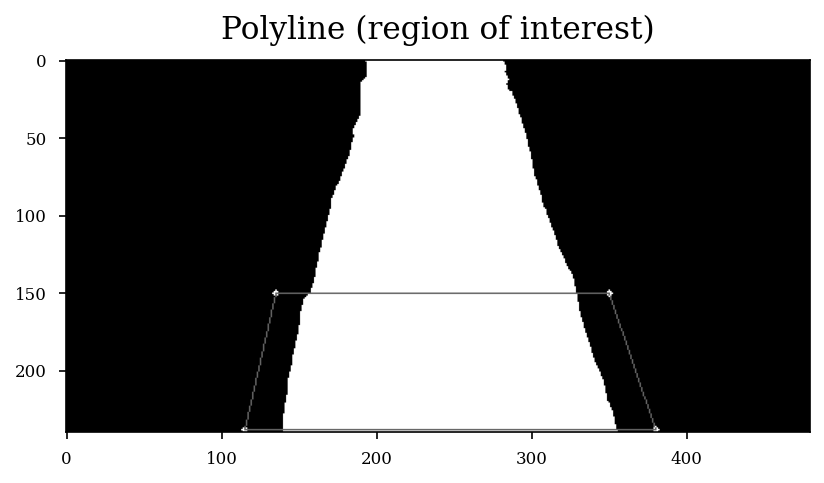

In [5]:
#polygon's vertices
p1 = (135,150)
p2 = (350, 150)
p3 = (115, 238)
p4 = (380, 238)

#mark the dots in the image
cv.circle( capture_bin,
          p1, #circle's center
          2, #radius
          (255, 0, 0), #color
          -1 #thickness
         )
cv.circle( capture_bin, p2, 2, (255, 0, 0), -1 )
cv.circle( capture_bin, p3, 2, (255, 0, 0), -1 )
cv.circle( capture_bin, p4, 2, (255, 0, 0), -1 )

#obtener polylines
pts_polygon = np.array( [ [ p1[0], p1[1] ],
                         [ p2[0], p2[1] ],
                         [ p4[0], p4[1] ],
                         [ p3[0], p3[1] ] ], dtype = np.int32 )
pts_polygon = pts_polygon.reshape( (-1, 1, 2) )
cv.polylines( img= capture_bin,
             pts = [pts_polygon],
             isClosed = True,
             color = (100,100,100)
            )

#visualizar los puntos y las líneas


#mostrar la imagen
plt.figure( facecolor='white', dpi = 150 )
plt.axes().set_facecolor('white')

plt.imshow( capture_bin, cmap = 'gray' )

plt.title( 'Polyline (region of interest)', size = 15, pad = 10 )
plt.show()

### Aerial view

With our region of interest defined, it is time to obtain the transformation matrix to obtain the area view, how?:

1. For the perspective transformation, we need a 3x3 transformation matrix.
2. To find this transformation matrix, we need 4 points in the input image and the corresponding points in the output image. Among these 4 points, 3 of them must not be collinear. Then the transformation matrix can be found by the function **`cv.getPerspectiveTransform()`** . Then we apply **`cv.warpPerspective()`** with this 3x3 transformation matrix.


#### Transformation matrix

The 4 points to transform are the polygon's vertices:

In [6]:
pts1_carretera = np.float32( [ [p1[0], p1[1]],
                              [p2[0], p2[1]],
                              [p3[0], p3[1]],
                              [p4[0], p4[1]] ] )

The final array of points are:

In [7]:
interest = (480,240)
pts2_carretera = np.float32( [ [0,0], 
                              [interest[0], 0], 
                              [0, interest[1]], 
                              [interest[0], interest[1]] ] )

Obtain the transformation matrix:

In [8]:
transformation_matrix = cv.getPerspectiveTransform( pts1_carretera, pts2_carretera )

Apply the transormation in the image:

In [9]:
capture_bin_transformed = cv.warpPerspective( capture_bin,
                                             transformation_matrix,
                                             interest
                                            )

Show the results

Text(0.5, 1.0, 'Aerial view')

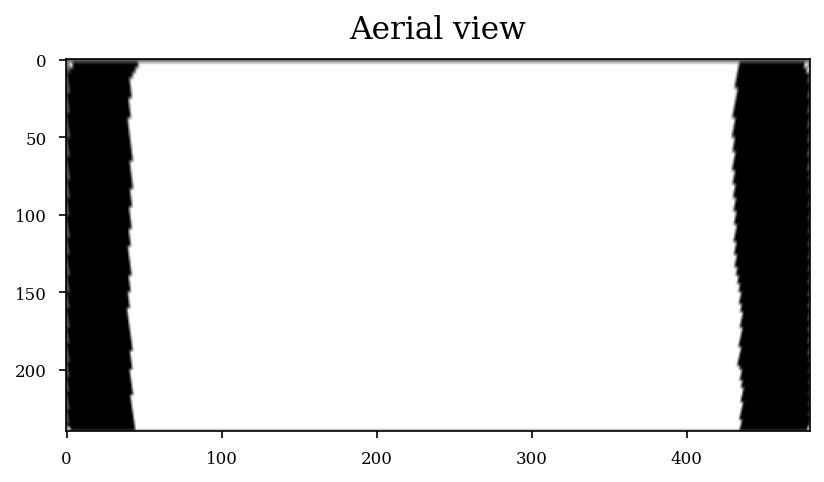

In [10]:
plt.figure(
           facecolor = '#FFFFFF',
          dpi = 150,
          )
plt.axes().set_facecolor('white')
plt.imshow( capture_bin_transformed, cmap = 'gray' )

plt.title('Aerial view', size = 15, pad = 10)

## Region of interest and polyline functions

In [11]:
def poly_interest(image, 
                  pt = [ (135,150), (350, 150), (380, 238), (115, 238) ],
                  color = (100,100,100),
                  closed = True
                 ):
    polygon_vert = np.array(pt)
    polygon_vert = polygon_vert.reshape((-1,1,2))
    return cv.polylines(image, [polygon_vert], closed, color)

In [12]:
def region_interest(image,
                 pt = [ (135,150), (350, 150), (115, 238), (380, 238) ],
                 pref_size = (480, 240) ):
    pts1 = np.float32( pt )
    pts2 = np.float32( [ [0,0],
                        [pref_size[0], 0],
                        [0, pref_size[1]], 
                        pref_size ] )
    matrix = cv.getPerspectiveTransform( pts1, pts2 )
    img_wrap = cv.warpPerspective( image, matrix, pref_size )
    return (img_wrap)

### Test **`poly_interest`** and **`region_interest`**

Text(0.5, 1.0, 'Aerial View')

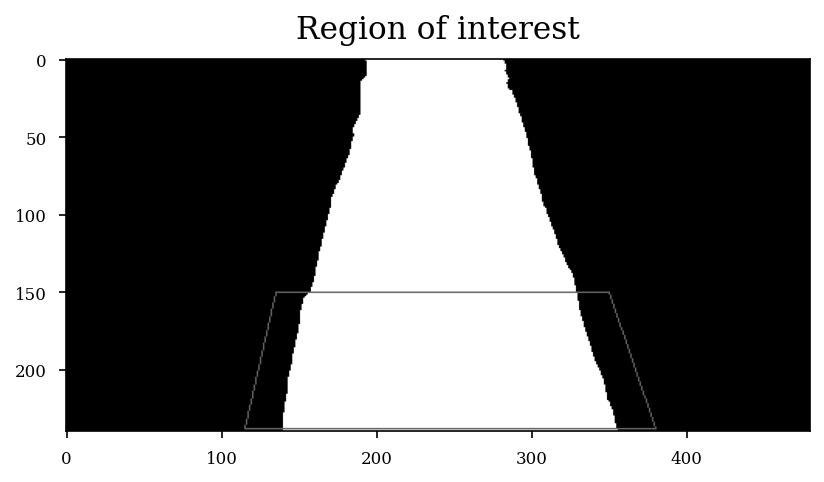

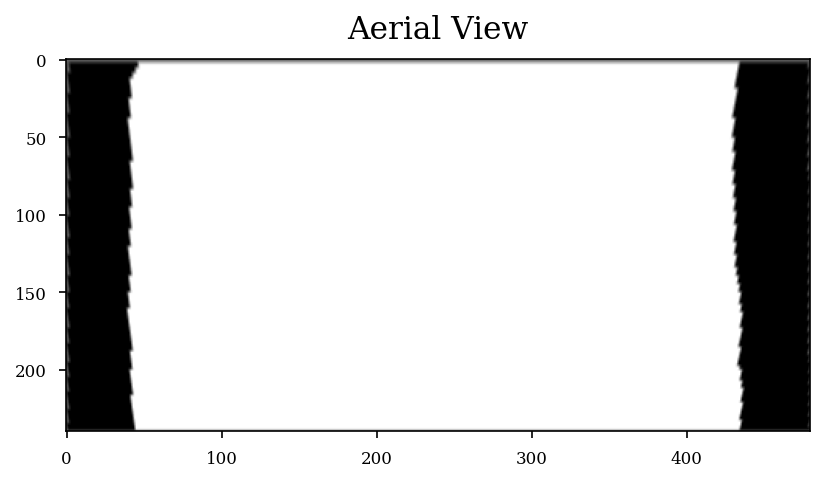

In [13]:
capture = cv.imread( 'data/test_image.jpg' )
capture_bin = binarization(capture)
capture_bin = poly_interest(image=capture_bin)
plt.figure(
           facecolor = '#FFFFFF',
          dpi = 150,
          )
plt.axes().set_facecolor('white')
plt.imshow( capture_bin, cmap = 'gray' )
plt.title('Region of interest', size = 15, pad = 10)
capture_bin_interest = region_interest(image=capture_bin)

plt.figure( 
           facecolor = '#FFFFFF',
          dpi = 150,
          )
plt.axes().set_facecolor('white')
plt.imshow( capture_bin_interest, cmap = 'gray' )
plt.title('Aerial View', size = 15, pad = 10)

# Add **`poly_interest`** and **`region_interest`** to the video

```Python
video = cv.VideoCapture("data/video_road.mp4")
while(video.isOpened()):
    ret, frame = video.read()
    if ret:
        cv.imshow("Original video", frame)
        img_bin = binarization(frame)
        img_bin = poly_interest(image=img_bin)
        cv.imshow("Binarized video", img_bin)
        img_interest = region_interest(image=img_bin)
        cv.imshow("Aerial view", img_interest)
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
video.release()
cv.destroyAllWindows()
```
(The whole code is in the **`L02_region_interest_video.py`** file)

# Direction algorithm

## Midpoint

### Step by step

1. To obtain the midpoint we will have to select a region close to the observer. Let us assume that the region we select is the following array:

\begin{equation*}
R_{\text{c}} = 
\begin{bmatrix}
0 & 0 & 255 & 255 & 255 & 255 & 255 & 0 & 0 \\
0 & 0 & 255 & 255 & 255 & 255 & 255 & 0 & 0 \\
0 & 0 & 255 & 255 & 255 & 255 & 255 & 0 & 0 \\
0 & 0 & 255 & 255 & 255 & 255 & 255 & 0 & 0
\end{bmatrix}
\end{equation*}

In [14]:
R_c = np.array( [ [0,0,255,255,255,255,255,0,0] ]*4 )
R_c

array([[  0,   0, 255, 255, 255, 255, 255,   0,   0],
       [  0,   0, 255, 255, 255, 255, 255,   0,   0],
       [  0,   0, 255, 255, 255, 255, 255,   0,   0],
       [  0,   0, 255, 255, 255, 255, 255,   0,   0]])

2. The next step is to obtain a summation, but not of all the elements of the matrix, only the elements of the columns.

\begin{equation*}
\text{Sum}_{\text{ col} } = 
\begin{bmatrix}
0 & 0 & 1020 & 1020 & 1020 & 1020 & 1020 & 0 & 0
\end{bmatrix}
\end{equation*}

This with NumPy is specified to be on the axis of the columns ( **`axis= 0`** ).

In [15]:
Sum_col = np.sum(R_c, axis=0)
Sum_col

array([   0,    0, 1020, 1020, 1020, 1020, 1020,    0,    0])

To find the index of the midpoint we carry out the dot product of the index vector of $\mathrm{R_c}$ and the vector $\text{Sum}_{\text{col}}$ and then divide by the sum of the elements of $\text{Sum}_{\text{col}}$:

\begin{equation*}
\dfrac{ 
\text{Sum}_{\text{col}}
\cdot
\text{Index}(\text{Sum}_{\text{col}}) 
}{\sum\limits_{i=0}^{n}\text{Sum}_{\text{col }i}}
\end{equation*}

In [16]:
Index_R_c = np.arange(len(Sum_col))

mid = np.dot(Sum_col,Index_R_c)/np.sum(Sum_col)
mid

4.0

### Step by step (images)

#### Region of interest

Text(0.5, 1.0, 'Aerial View')

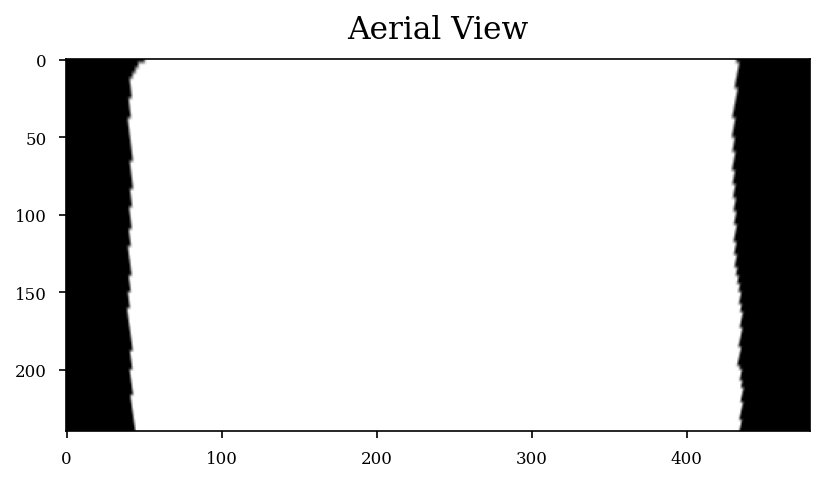

In [17]:
capture = cv.imread( 'data/test_image.jpg' )
capture_bin = binarization(capture)
capture_bin_interest = region_interest(image=capture_bin)

plt.figure( 
           facecolor = '#FFFFFF',
          dpi = 150,
          )
plt.axes().set_facecolor('white')
plt.imshow( capture_bin_interest, cmap = 'gray' )
plt.title('Aerial View', size = 15, pad = 10)

#### Close up

Text(0.5, 1.0, 'Close up')

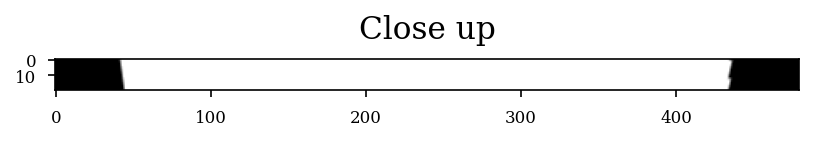

In [18]:
capture_closer = capture_bin_interest[ 220:, : ]

plt.figure( 
           facecolor = '#FFFFFF',
          dpi = 150,
          )
plt.axes().set_facecolor('white')
plt.imshow( capture_closer, cmap = 'gray' )

plt.title('Close up', size = 15, pad = 10)

#### Sum of columns

In [19]:
sum_columns = capture_closer.sum(axis=0)
sum_columns

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,  112, 1036, 2757,
       4366, 5084, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100,
       5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100,
       5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100,
       5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100,
       5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100,
       5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100,
       5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100,
       5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100,
       5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100, 5100,
       5100, 5100, 5100, 5100, 5100, 5100, 5100, 51

#### Finding midpoint

\begin{equation*}
\dfrac{ 
\text{Sum}_{\text{col}}
\cdot
\text{Index}(\text{Sum}_{\text{col}}) 
}{\sum\limits_{i=0}^{n}\text{Sum}_{\text{col }i}}
\end{equation*}

In [20]:
x_index = np.arange(len(sum_columns))
mid = int(( np.dot(x_index, sum_columns) ) / np.sum(sum_columns))
mid

238

#### Visualizing final result

Text(0.5, 1.0, 'Aerial View')

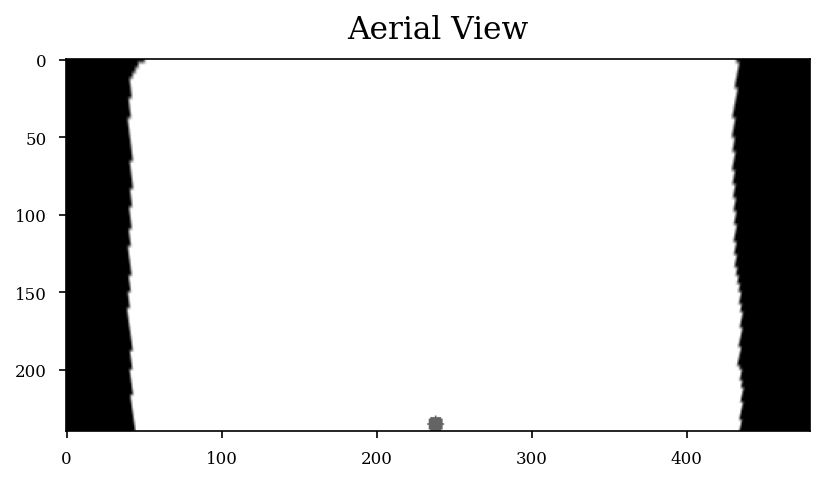

In [21]:
capture = cv.imread( 'data/test_image.jpg' )
capture_bin = binarization(capture)
capture_bin_interest = region_interest(image=capture_bin)

#midpoint
cv.circle( capture_bin_interest, (mid,235), 5, (100,100,100), -1 )

plt.figure( 
           facecolor = '#FFFFFF',
          dpi = 150,
          )
plt.axes().set_facecolor('white')
plt.imshow( capture_bin_interest, cmap = 'gray' )
plt.title('Aerial View', size = 15, pad = 10)

### Midpoint function

In [22]:
def mid_point( image ):
    close_up = image[ 220:, : ]
    sum_columns = close_up.sum(axis=0)
    indexes = np.arange( len(sum_columns) )
    midPoint = int( np.dot(indexes, sum_columns)/np.sum(sum_columns) )
    return midPoint

## The text

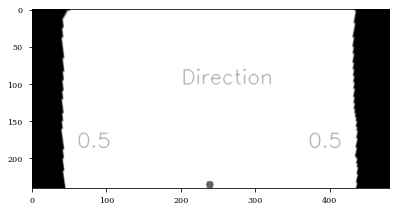

In [23]:
#use all functions
capture = cv.imread( 'data/test_image.jpg' )
capture_bin = binarization(capture)
capture_interest = region_interest(image=capture_bin)
midPoint = mid_point(capture_interest)

#texts
text1 = str(0.50)
text2 = str(0.50)
text3 = 'Direction'
#font
font = cv.FONT_HERSHEY_SIMPLEX
#origin of the text
org1 = (60, 185)
org2 = (370, 185)
org3 = (200, 100)
#size
fontScale = 0.9
# Colour
colour = (150, 150, 150)
# Grosor de la linea del texto
thickness = 1

# Usamos la función cv.putText() para agregar texto
cv.putText(capture_interest, text1, org1, font, fontScale,
colour, thickness, cv.LINE_AA, False)
cv.putText(capture_interest, text2, org2, font, fontScale,
colour, thickness, cv.LINE_AA, False)
cv.putText(capture_interest, text3, org3, font, fontScale,
colour, thickness, cv.LINE_AA, False)
plt.figure(facecolor='white')
plt.axes().set_facecolor('white')
cv.circle(capture_interest, (midPoint,235), 5, (100, 100,100 ), -1) ;
plt.imshow(capture_interest,cmap='gray')
plt.show()

### Normalized sum functions

In [24]:
def left_sum( image, midpoint ):
    return np.round(np.sum( image[:, :midpoint].sum(axis = 0) )/(255*image.shape[0]*image.shape[1]),2)

def right_sum( image, midpoint ):
    return np.round(np.sum( image[:, midpoint:].sum(axis = 0) )/(255*image.shape[0]*image.shape[1]),2)

These functions give us how much to left or to the right our car is heading

## Add **`mid_point`** and the direction algorithm to the video

```Python
font = cv.FONT_HERSHEY_TRIPLEX

org1 = (60, 185)
org2 = (370, 185)
org3 = (200, 100)

fontScale = 0.7

colour = (150, 150, 150)

thickness = 1
#==================================== CODE =====================================
video = cv.VideoCapture('data/video_road_v2.mp4')
while(video.isOpened()):
    ret, frame = video.read()
    if ret:
        cv.imshow("Original video", frame)
        img_bin = binarization(frame)
        img_bin = poly_interest(image=img_bin)
        cv.imshow("Binarized video", img_bin)
        img_interest = region_interest(image=img_bin)
        midPoint = mid_point(img_interest)
        left = left_sum(img_interest, midPoint)
        right = right_sum(img_interest, midPoint)
        cv.putText(img_interest, str(left), org1, font, fontScale,
                 colour, thickness, cv.LINE_AA, False)
        cv.putText(img_interest, str(right), org2, font, fontScale,
                 colour, thickness, cv.LINE_AA, False)
        delta = left - right
        if delta > 0.05:
            heading = "Left"
        elif delta < 0.05:
            heading = "Right"
        else:
            heading = "Straight"
        cv.putText(img_interest, heading, org3, font, fontScale,
                 colour, thickness, cv.LINE_AA, False)
        cv.circle(img_interest, (midPoint,235),5,(100,100,100),-1)
        cv.imshow("Aerial view", img_interest)
        time.sleep(0.00000001)
        if cv.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break
video.release()
cv.destroyAllWindows()
```
(The whole code is in the **`L02_final_result.py`** file)

## What is **`delta`** ?

**`delta`** is a parameter that helps us to define the direction in which the car (video) is heading, the smaller the delta, the more sensitive to changes is. 